In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean
from numpy import std
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import GridSearchCV

## Read data and fill missing values

In [2]:
df = pd.read_csv("./stroke-data.csv") # Read CSV
df.drop('id', axis=1, inplace=True) # Drop uneeded ID
df['bmi'].fillna(df['bmi'].mean(), inplace=True) # BMI missing value imputation

## Visualize data

<AxesSubplot:>

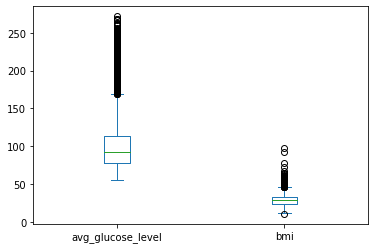

In [3]:
# Show outliers
df[['avg_glucose_level', 'bmi']].plot(kind='box')

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

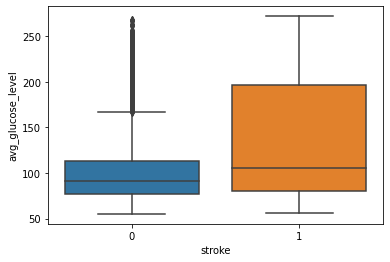

In [4]:
# Compare cases of stroke to avg_glucose_level
# Dave Parth (2021) - https://www.analyticsvidhya.com/blog/2021/05/how-to-create-a-stroke-prediction-model/
sns.boxplot(data=df, x='stroke', y='avg_glucose_level')

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

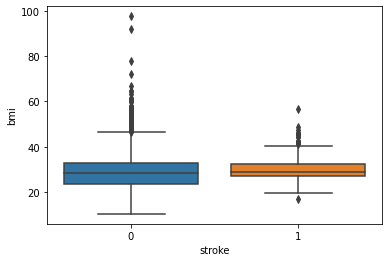

In [5]:
# Compare bmi to stroke
sns.boxplot(data=df, x='stroke', y='bmi')

In [6]:
# Isolate continuous data for convenience
continuous_data = df[['avg_glucose_level', 'bmi', 'age']]

<AxesSubplot:xlabel='bmi', ylabel='avg_glucose_level'>

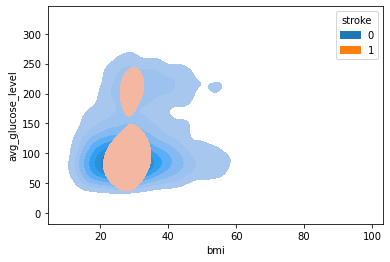

In [7]:
# Compare avg_glucose_level and bmi against stroke
sns.kdeplot(data=continuous_data, x='bmi', y='avg_glucose_level', hue=df['stroke'], shade=True, thresh=0.05)

<AxesSubplot:xlabel='avg_glucose_level', ylabel='age'>

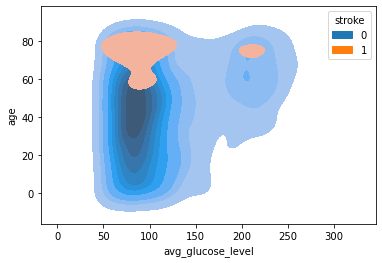

In [8]:
# Compare avg_glucose_level and age against stroke
sns.kdeplot(data=continuous_data, x='avg_glucose_level', y='age', hue=df['stroke'], shade=True, thresh=0.05)

<AxesSubplot:xlabel='bmi', ylabel='age'>

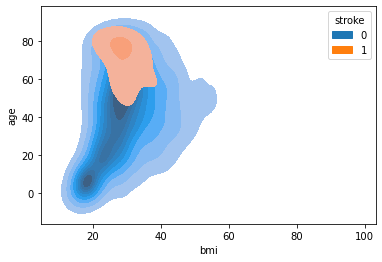

In [9]:
# Compare bmi and age against stroke
sns.kdeplot(data=continuous_data, x='bmi', y='age', hue=df['stroke'], shade=True, thresh=0.05)

<AxesSubplot:xlabel='stroke', ylabel='gender'>

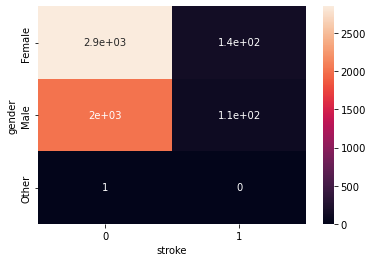

In [10]:
# Compare gender against stroke
sns.heatmap(pd.crosstab(df['gender'], df['stroke']), annot=True)

<AxesSubplot:xlabel='stroke', ylabel='work_type'>

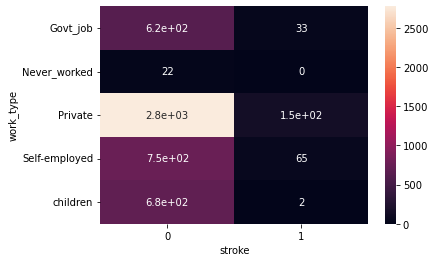

In [11]:
# Compare work_type against stroke
sns.heatmap(pd.crosstab(df['work_type'], df['stroke']), annot=True)

<AxesSubplot:xlabel='stroke', ylabel='hypertension'>

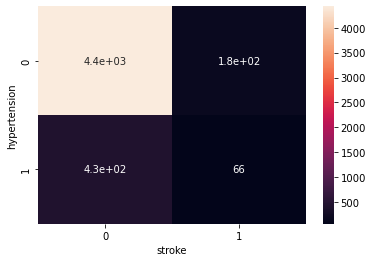

In [12]:
# Compare hypertension against stroke
sns.heatmap(pd.crosstab(df['hypertension'], df['stroke']), annot=True)

<AxesSubplot:xlabel='stroke', ylabel='ever_married'>

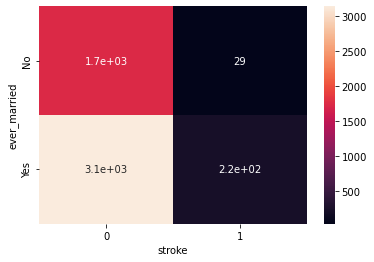

In [13]:
# Compare ever_married against stroke
sns.heatmap(pd.crosstab(df['ever_married'], df['stroke']), annot=True)

<AxesSubplot:xlabel='stroke', ylabel='heart_disease'>

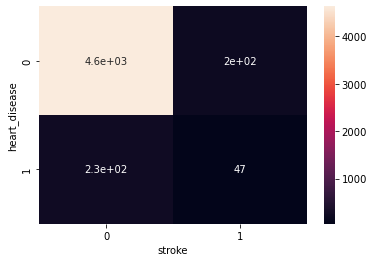

In [14]:
# Compare heart_disease against stroke
sns.heatmap(pd.crosstab(df['heart_disease'], df['stroke']), annot=True)

<AxesSubplot:xlabel='stroke', ylabel='smoking_status'>

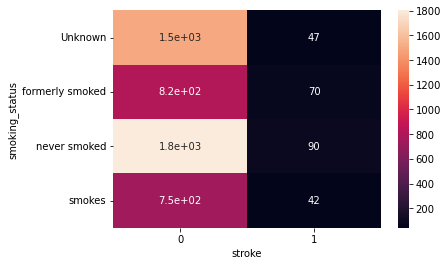

In [15]:
# Compare smoking_status against stroke
sns.heatmap(pd.crosstab(df['smoking_status'], df['stroke']), annot=True)

In [16]:
df.drop('smoking_status', axis=1, inplace=True) # Drop smoking_status

<AxesSubplot:xlabel='stroke', ylabel='Residence_type'>

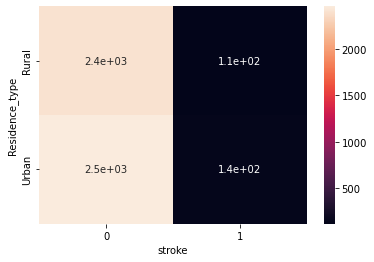

In [17]:
# Compare Residence_type against stroke
sns.heatmap(pd.crosstab(df['Residence_type'], df['stroke']), annot=True)

## Catagory Encoding

In [18]:
ohe = OneHotEncoder()

catagory_names = ['gender', 'ever_married', 'work_type', 'Residence_type'] 
encoded_catagories = ohe.fit_transform(df[catagory_names]) # Encode catagories

column_names = ohe.get_feature_names_out(catagory_names) # Get new catagory names ('gender' -> 'gender_Female', 'gender_Male', ...)

temp_df = pd.DataFrame(encoded_catagories.todense(), columns = column_names) # Create new dataframe with new catagories

df = df.drop(catagory_names, axis=1) # Remove old catagories
df = pd.concat([df, temp_df], axis=1) # Add new catagories

## Separate input and output sets

In [19]:
X = df.drop('stroke', axis=1) # Remove target feature from input
y = df['stroke'] # Extract target feature for output

## Balance dataset

In [20]:
# SMOTENC requires a list of indicies for the catagories within the dataset
catagory_column_indicies = []
for col in column_names:
    catagory_column_indicies.append(X.columns.get_loc(col))

smote_nc = SMOTENC(categorical_features=catagory_column_indicies, random_state=10)
X, y = smote_nc.fit_resample(X, y) # Add new entries to balance dataset

## Split dataset into training and testing sets

In [21]:
# Training set 80%, testing set 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Train default random forest model

In [22]:
model = RandomForestClassifier() # Create random forest model
start = time.time()
model.fit(X_train, y_train) # Train model
stop = time.time()

## Evaluate performance of default model

In [23]:
y_pred = model.predict(X_test)

# Cross validation for default model
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print("Default Random Forest Performance Metrics:")
print("----------------------------------")
print("Training score: " + str(model.score(X_train, y_train)))
print("Test score: " + str(model.score(X_test, y_test)))
print('Cross Validation Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print("Training time: " + str(stop - start))
print("----------------------------------")
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred)) 

Default Random Forest Performance Metrics:
----------------------------------
Training score: 1.0
Test score: 0.9383033419023136
Cross Validation Accuracy: 0.938 (0.009)
Training time: 0.41428112983703613
----------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       975
           1       0.93      0.95      0.94       970

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945

Confusion Matrix
[[901  74]
 [ 46 924]]


## Find likely optimal n_estimators

In [24]:
test_scores = []
optimal_n_estimators = 0
# Run time ~ 1.27 minutes 
for i in range(1, 201):
    temp_model = RandomForestClassifier(n_estimators=i) # Create new model with current amount of n_estimators
    temp_model.fit(X_train, y_train) # Train the new model
    temp_model_pred = temp_model.predict(X_test) 
    test_scores.append(accuracy_score(temp_model_pred, y_test)) # Add the score the current model achieved to a list
    if test_scores[i-1] == max(test_scores): optimal_n_estimators = i # If its the best score achieved so far, store the number of n_estimators that achieved it

In [25]:
# Print results
print(optimal_n_estimators)
print(test_scores[optimal_n_estimators-1])

169
0.9424164524421594


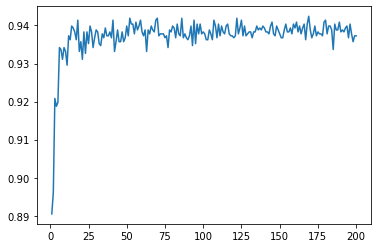

In [26]:
# Plot results
x = np.array(range(1, 201))
y = np.array(test_scores)
plt.plot(x, y)

## Find optimal hyperparameters

In [ ]:
param_grid = {
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'n_estimators': [int(x) for x in np.linspace(start = 25, stop = 100, num = 5)],
    'max_depth': [*[int(x) for x in np.linspace(10, 110, num = 11)], None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}
# Run time ~ 46 minutes 
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, verbose=3)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

## Create and train optimised model

In [31]:
# Best previously found parameters
prev_best_params = {
    'bootstrap': False, 
    'max_depth': 60, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 1, 
    'min_samples_split': 5, 
    'n_estimators': 81
}

optimised_model = RandomForestClassifier(**CV_rfc.best_params_) # or **prev_best_params
start = time.time()
optimised_model.fit(X_train, y_train)
stop = time.time()
optimised_model.score(X_test, y_test)

0.9377892030848329

## Evaluate optimised model performance

In [ ]:
optimised_model_pred = optimised_model.predict(X_test)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(optimised_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print("Optimised Random Forest Performance Metrics:")
print("----------------------------------")
print("Training score: " + str(optimised_model.score(X_train, y_train)))
print("Test score: " + str(optimised_model.score(X_test, y_test)))
print('Cross Validation Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print("Training time: " + str(stop - start))
print("----------------------------------")
print("Classification Report")
print(classification_report(y_test, y_pred))

<AxesSubplot:>

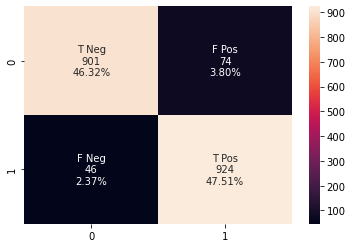

In [33]:
rf_cm = confusion_matrix(y_test, y_pred)
# Dennis T (2019) - https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ['T Neg','F Pos','F Neg','T Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in rf_cm.flatten()/np.sum(rf_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rf_cm, annot=labels, fmt='')